# Import Required Libraries
Import the necessary libraries, including torch, numpy, pandas, and the custom modules for preprocessing and model definition.

In [1]:
%pip install --extra-index-url https://download.pytorch.org/whl/cu118 torch==2.2.0 numpy==1.25.1 tqdm==4.66.2 pandas==1.1.4 h5py==3.12.1 matplotlib==3.8.2 matplotlib-inline==0.1.7 click==8.1.7 scikit-learn==0.24.2 x-transformers==1.16.23
%pip install --extra-index-url https://data.pyg.org/whl/torch-2.2.0+cu118.html torch_scatter 

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://data.pyg.org/whl/torch-2.2.0+cu118.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      Traceback (most recent call last):
        File "/Users/diogoadegas/Selective_SSM_for_EHR_Classification/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/Users/diogoadegas/Selective_SSM_for_EHR_Classification/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook

In [2]:

%pip install torch_scatter --extra-index-url https://data.pyg.org/whl/torch-2.2.0+cu118.html
# Import Required Libraries


Looking in indexes: https://pypi.org/simple, https://data.pyg.org/whl/torch-2.2.0+cu118.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      Traceback (most recent call last):
        File "/Users/diogoadegas/Selective_SSM_for_EHR_Classification/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/Users/diogoadegas/Selective_SSM_for_EHR_Classification/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "/Users/diogoadegas/Selective_SSM_for_EHR_Classification/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/

In [3]:

import torch
import numpy as np
import pandas as pd
import os
import json
import random
import h5py
import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
import matplotlib.pyplot as plt
from mortality_part_preprocessing import load_pad_separate, PairedDataset, MortalityDataset
from mortality_classification import train_test
from models.mamba import EncoderClassifierMamba
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/Users/diogoadegas/Selective_SSM_for_EHR_Classification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/diogoadegas/Selective_SSM_for_EHR_Classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'torch_scatter'

# Load and Preprocess the Physionet Dataset
Load the Physionet dataset and preprocess it using the provided preprocessing functions.

In [4]:
# Define a custom dataset class for PhysioNet 2012
class PhysioNet2012Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
# Load and preprocess the PhysioNet 2012 dataset
def load_physionet2012(base_path, split_index):
    train_data = np.load(os.path.join(base_path, f"train_physionet2012_{split_index}.npy"), allow_pickle=True)
    val_data = np.load(os.path.join(base_path, f"validation_physionet2012_{split_index}.npy"), allow_pickle=True)
    test_data = np.load(os.path.join(base_path, f"test_physionet2012_{split_index}.npy"), allow_pickle=True)
    return train_data, val_data, test_data

# Define the dataset ID and base path
dataset_id = "physionet2012"
base_path = "./P12data/split_1"

# Load and preprocess the dataset
train_pair, val_data, test_data = load_pad_separate(dataset_id, base_path, split_index=1)

# Display the shapes of the datasets
print(f"Training pairs: {len(train_pair)}")
print(f"Validation data: {len(val_data)}")
print(f"Test data: {len(test_data)}")

Loading preprocessed datasets from ./processed_datasets
Loaded dataset from ./processed_datasets/physionet2012_1_pos.h5
Loaded dataset from ./processed_datasets/physionet2012_1_neg.h5
Loaded dataset from ./processed_datasets/physionet2012_1_val.h5
Loaded dataset from ./processed_datasets/physionet2012_1_test.h5
Training pairs: 4026
Validation data: 1199
Test data: 1199


# Define the Mamba Model
Define the Mamba model architecture using the provided Mamba model class.

In [7]:
# Define the Mamba Model

# Define the Mamba model architecture using the provided Mamba model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Mamba model with the specified parameters
mamba_model = EncoderClassifierMamba(
    device=device,
    pooling="mean",
    num_classes=2,
    sensors_count=37,
    static_count=8,
    layers=3,
    d_model=256,
    ssm_state_size=64,
    expand_factor=1,
    dropout=0.2
).to(device)

# Print the model architecture
print(mamba_model)

The fast path is not available because on of `(selective_state_update, causal_conv1d_fn, causal_conv1d_update)` is None. Falling back to the naive implementation. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d


EncoderClassifierMamba(
  (mamba_model): Mamba2ForCausalLM(
    (backbone): Mamba2Model(
      (embeddings): Embedding(0, 256)
      (layers): ModuleList(
        (0-2): 3 x Mamba2Block(
          (norm): Mamba2RMSNorm()
          (mixer): Mamba2Mixer(
            (act): SiLU()
            (conv1d): Conv1d(384, 384, kernel_size=(4,), stride=(1,), padding=(3,), groups=384)
            (in_proj): Linear(in_features=256, out_features=641, bias=False)
            (norm): MambaRMSNormGated()
            (out_proj): Linear(in_features=256, out_features=256, bias=False)
          )
        )
      )
      (norm_f): Mamba2RMSNorm()
    )
    (lm_head): Linear(in_features=256, out_features=0, bias=False)
  )
  (sensor_embedding): Linear(in_features=74, out_features=256, bias=True)
  (static_embedding): Linear(in_features=8, out_features=8, bias=True)
  (nonlinear_merger): Linear(in_features=264, out_features=264, bias=True)
  (classifier): Linear(in_features=264, out_features=2, bias=True)
  (t

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


# Train the Mamba Model
Train the Mamba model for a few epochs to demonstrate the training process.

In [9]:
# Train the Mamba Model

# Define training parameters
output_path = "./ehr_classification_results/"
epochs = 1  # Train for a few epochs to demonstrate the training process
batch_size = 64
lr = 0.001
patience = 2
early_stop_criteria = "f1-score"
loss_function = "bce_with_logits"

In [ ]:


# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Train the Mamba model
loss, accuracy_score, auprc_score, auc_score, f1_score = train_test(
    train_pair=train_pair,
    val_data=val_data,
    test_data=test_data,
    output_path=output_path,
    model_type="mamba",
    model_args={
        "pooling": "mean",
        "layers": 4,
        "mamba_d_model": 256,
        "mamba_state_size": 64,
        "mamba_expand_factor": 1,
        "dropout": 0.2
    },
    batch_size=batch_size,
    epochs=epochs,
    lr=lr,
    patience=patience,
    early_stop_criteria=early_stop_criteria,
    loss_function=loss_function
)

# Display the training results
print(f"Training completed with the following results:")
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy_score}")
print(f"AUPRC: {auprc_score}")
print(f"AUROC: {auc_score}")
print(f"F1 Score: {f1_score}")

# Evaluate the Mamba Model
Evaluate the trained Mamba model on the test dataset and display the results.

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [01:49<00:00,  5.76s/it]

Evaluation Results:
Accuracy: 0.8390325271059216
AUROC: 0.8581359364689285
AUPRC: 0.5229090350208284
F1 Score: 0.5089058524173028


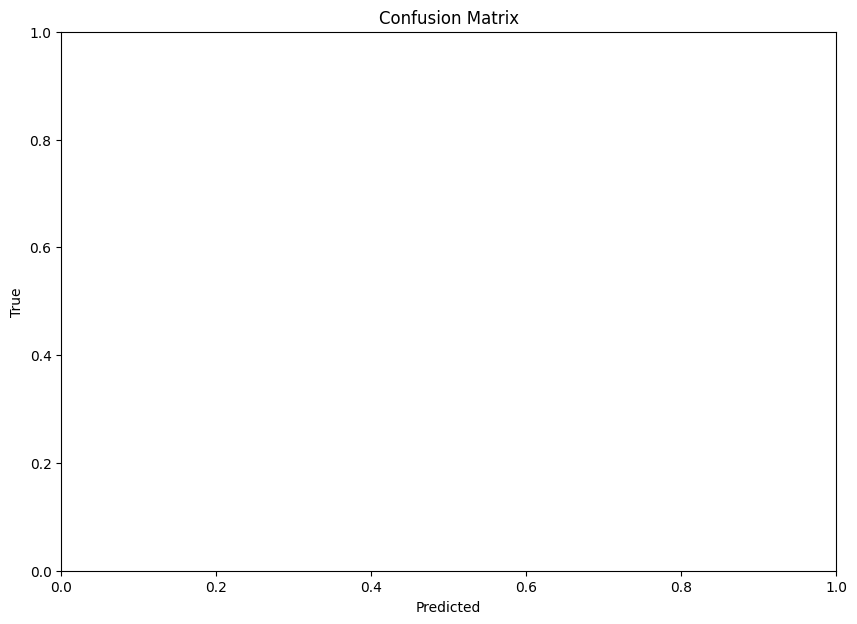

In [12]:
# Evaluate the Mamba Model

# Load the best model from the training process
mamba_model.load_state_dict(torch.load(f"checkpoint.pt", map_location=torch.device('cpu')), strict=False)

# Set the model to evaluation mode
mamba_model.eval()

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, collate_fn=MortalityDataset.non_pair_collate_fn_truncate, pin_memory=True)

# Initialize lists to store the true labels and predictions
true_labels = []
predictions = []
all_probs = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for batch in tqdm.tqdm(test_dataloader, total=len(test_dataloader)):
        data, times, static, labels, mask, delta = batch
        data, times, static, mask, delta = data.to(device), times.to(device), static.to(device), mask.to(device), delta.to(device)
        
        # Get model predictions
        outputs = mamba_model(x=data, static=static, time=times, sensor_mask=mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        
        # Store the true labels, predictions, and probabilities
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted_labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert all_probs to a numpy array
all_probs = np.array(all_probs)

# Ensure the lengths of true_labels and all_probs match
assert len(true_labels) == len(all_probs), f"Length mismatch: {len(true_labels)} true labels vs {len(all_probs)} probabilities"




Evaluation Results:
Accuracy: 0.8390325271059216
AUROC: 0.8581359364689285
AUPRC: 0.5229090350208284
F1 Score: 0.5089058524173028


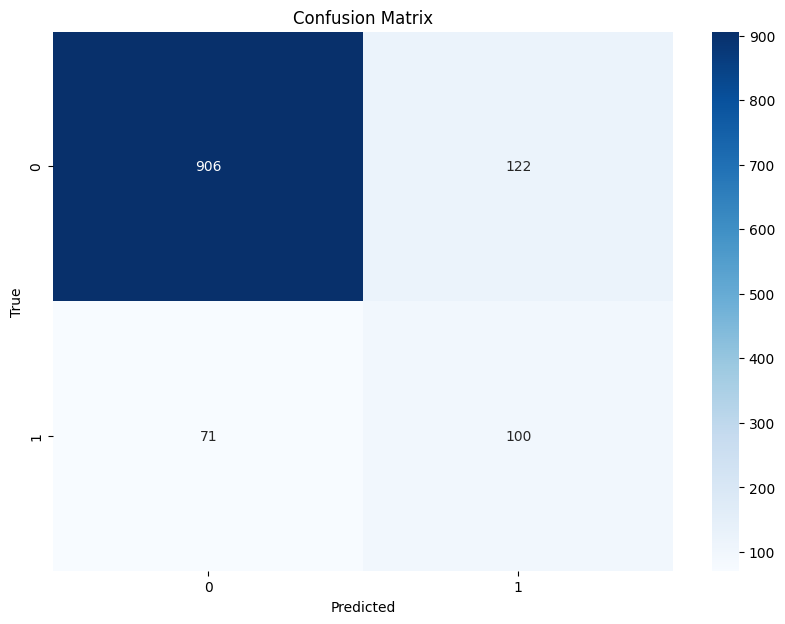

In [14]:
import seaborn as sns

# Calculate evaluation metrics
accuracy = metrics.accuracy_score(true_labels, predictions)
auroc = metrics.roc_auc_score(true_labels, all_probs[:, 1])
auprc = metrics.average_precision_score(true_labels, all_probs[:, 1])
f1 = metrics.f1_score(true_labels, predictions)

# Display the evaluation results
print(f"Evaluation Results:")
print(f"Accuracy: {accuracy}")
print(f"AUROC: {auroc}")
print(f"AUPRC: {auprc}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()